In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify.classifiers as classifiers
import datetime as dt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as tick
from matplotlib.patches import ConnectionPatch

In [2]:
def fmt_lbl(ax):
    for lbl in ax.get_legend().get_texts():
        label_text = (
            lbl.get_text()
            .replace("[", "")
            .replace("]", "")
            .replace(")", "")
            .replace("(", "")
        )
        lower = label_text.split(",")[0]
        upper = label_text.split(",")[1]
        new_text = f"{float(lower):,.0f} - {float(upper):,.0f}"
        lbl.set_text(new_text)

In [3]:
def plot_map(data):
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    world = world[(world.pop_est > 0) & (world.name != "Antarctica")]
    df = data[["iso_code", "total_cases"]].copy()
    world = world.merge(df, left_on="iso_a3", right_on="iso_code").dropna()
    fig, ax = plt.subplots(figsize=(18, 8))
    world.plot(
        column="pop_est", ax=ax, cmap="Reds", scheme="quantiles", k=5, legend=True
    )
    ax.set_title("COVID-19 Confirmed Cases Heat Map", fontdict={"fontsize": 18})
    ax.set_axis_off()
    ax.get_legend().set_bbox_to_anchor((0.0, 0.0, 0.2, 0.3))
    fmt_lbl(ax)
    plt.show()

In [4]:
def reformat_large_tick_values(tick_val, pos):
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val
    new_tick_format = str(new_tick_format)
    index_of_decimal = new_tick_format.find(".")
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]       
    return new_tick_format


In [5]:
def plot_world_trend(data):
    df = data[(data["iso_code"] == "OWID_WRL")].reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    total_cases = int(df.loc[df['date'].idxmax()]['total_cases'])
    total_deaths = int(df.loc[df['date'].idxmax()]['total_deaths'])
    fig, ax = plt.subplots(2, 1, figsize=[18, 8])
    ax[0].plot(
            pd.to_datetime(df["date"]),
            df["new_cases_smoothed"],
            "-",
            color="red",
        )
    ax[0].yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
    ax[0].text(pd.to_datetime('2019-09-01'), 600000 , f'{total_cases:,}', fontsize=30, style='italic')
    ax[0].text(pd.to_datetime('2019-09-01'), 500000 , "confirmed Cases", fontsize=16)
    ax[0].grid()
    ax[1].plot(
            pd.to_datetime(df["date"]),
            df["new_deaths_smoothed"],
            "-",
            color="red",
        )
    ax[1].yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
    ax[1].text(pd.to_datetime('2019-09-01'), 10000 , f'{total_deaths:,}', fontsize=30, style='italic',)
    ax[1].text(pd.to_datetime('2019-09-01'), 8000 , "deaths", fontsize=16)
    ax[1].grid()
    fig.tight_layout(pad=3.0)
    plt.show()

In [6]:
def populate_top15(data):
    df = data[data["iso_code"].str.contains("OWID") == False]
    df = df.fillna(method="ffill")
    idx = df.groupby(["location"])["date"].transform(max) == df["date"]
    df = df[idx].sort_values(by=["total_cases"], ascending=False)[
        [
            "location",
            "total_cases",
            "new_cases",
            "total_deaths",
            "new_deaths",
        ]
    ]
    df = df.rename(
        columns={
            "location": "Country",
            "total_cases": "Total Cases",
            "new_cases": "New Cases",
            "total_deaths": "Total Deaths",
            "new_deaths": "New Deaths",
            
        }
    )
    return df.head(15)

In [7]:
def plot_sub_ax(iso_code, df, ax):
    temp = df[df["iso_code"] == iso_code].reset_index(drop=True)
    ax.plot(
        pd.to_datetime(temp["date"]),
        temp["new_cases_smoothed"],
        "-",
        label=iso_code,
        color="red",
    )
    fmt = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(fmt)
    #locator = mdates.MonthLocator() 
    #ax.xaxis.set_major_locator(locator)
    ax.set_title(iso_code)
    ax.grid()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

In [8]:
def plot_new_cases(data):
    iso_codes = ["CHN", "USA", "DEU", "IND", "JPN", "KOR"]
    df = data[["iso_code", "location", "date", "new_cases_smoothed"]]
    df = df[df["iso_code"].isin(iso_codes)].reset_index(drop=True)
    fig, ax = plt.subplots(3, 2, figsize=[18, 10])
    fig.tight_layout(pad=3.0)
    z = 0
    for i, v in enumerate(iso_codes):
        n = i % 2
        if (i > 0) & (n == 0):
            z = z + 1
        plot_sub_ax(v, df, ax[z][n])  
    plt.show()

In [9]:
def plot_sub_pie(
    location, people_vaccinated, people_fully_vaccinated, people_rest, degree, ax1, ax2
):
    labels = ["Vaccinated", "Not vaccinated"]
    ratios = []
    ratios.append(people_vaccinated)
    ratios.append(people_rest - people_vaccinated)
    explode = [0.1, 0]
    angle = degree * ratios[0]
    ax1.pie(
        ratios, autopct="%1.1f%%", startangle=angle, labels=labels, explode=explode,
    )

    labels = ["Fully Vaccinated", "Partially Vaccinated"]
    ratios = []
    ratios.append(people_fully_vaccinated)
    ratios.append(people_vaccinated - people_fully_vaccinated)
    width = 0.2

    ax2.pie(
        ratios,
        autopct="%1.1f%%",
        startangle=angle,
        labels=labels,
        radius=0.5,
        textprops={"size": "smaller"},
    )
    ax1.set_title(location)
    theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
    center, r = ax1.patches[0].center, ax1.patches[0].r
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(
        xyA=(-width / 2, 0.5),
        xyB=(x, y),
        coordsA="data",
        coordsB="data",
        axesA=ax2,
        axesB=ax1,
    )
    con.set_color([0, 0, 0])
    con.set_linewidth(2)
    ax2.add_artist(con)
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(
        xyA=(-width / 2, -0.5),
        xyB=(x, y),
        coordsA="data",
        coordsB="data",
        axesA=ax2,
        axesB=ax1,
    )
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(2)

In [10]:
def plot_pie(data):
    iso_codes = ["OWID_WRL", "USA", "OWID_EUR", "IND"]
    degrees = [-5, 5, 8, 5]
    fig, ax = plt.subplots(2, 4, figsize=(18, 8))
    x = 0
    y = 0
    for i, v in enumerate(iso_codes):
        if (i % 2 == 0) & (i > 0):
            x = x + 1
        if y == len(iso_codes):
            y = 0
        df = data[(data["iso_code"] == v)].reset_index(drop=True)
        country = df.loc[0]["location"]
        people_vaccinated = int(df["people_vaccinated"].max())
        people_fully_vaccinated = int(df["people_fully_vaccinated"].max())
        people_rest = int(df["population"].max()) - people_vaccinated
        plot_sub_pie(
            country,
            people_vaccinated,
            people_fully_vaccinated,
            people_rest,
            degrees[i],
            ax[x][y],
            ax[x][y + 1],
        )
        y = y + 2
    plt.show()

In [11]:
def plot_death_age(data):
    df = data[
        (data["State"] == "United States")
        & (data["Sex"] != "All Sexes")
        & (data["Age Group"] != "All Ages")
        & (data["Data As Of"] == "04/21/2021")
        & (data["Group"] == "By Total")
    ]
    male = df[df["Sex"] == "Male"]
    female = df[df["Sex"] == "Female"]
    y = np.arange(len(male))
    fig, axes = plt.subplots(figsize=(18, 8), ncols=2, sharey=True)
    axes[0].set_yticks(y)
    axes[0].set_yticklabels(male["Age Group"])
    axes[0].invert_xaxis()
    axes[0].yaxis.tick_right()
    axes[0].set_title("Male")
    axes[1].set_title("Female")
    axes[0].barh(y, male["COVID-19 Deaths"], align="center", color="blue", zorder=10)
    for i, v in enumerate(male["COVID-19 Deaths"]):
        axes[0].text(v + 10000, i - 0.1, str(v), color="blue", fontweight="bold")
    axes[1].barh(y, female["COVID-19 Deaths"], align="center", color="red", zorder=10)
    for i, v in enumerate(female["COVID-19 Deaths"]):
        axes[1].text(v + 4000, i - 0.1, str(v), color="blue", fontweight="bold")
    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)
        ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
    fig.subplots_adjust(wspace=0.23)
    plt.show()

In [12]:
def plot_confirmed_age(data):
    df = data[data["OBJECTID"] == data["OBJECTID"].max()]
    df = df.drop(["OBJECTID", "DATE", "Age_Unknown"], axis=1)
    y = np.arange(len(df.columns))
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_yticks(y)
    ax.set_yticklabels(df.columns)
    ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.barh(y, df.iloc[0])
    plt.ylabel("Age Group")
    plt.xlabel("Confirmed Cases")
    plt.show()

In [13]:
filepath = r"./owid-covid-data_latest.csv"
data = pd.read_csv(filepath, low_memory=False)

# The Coronavirus (aka COVID-19),  a major turning point in human history

### History and its current global states 

Coronavirus disease 2019 (COVID-19), also known as the coronavirus or COVID, is a contagious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The first known case was identified in Wuhan, China, in December 2019.7.

This disease has since spread wildly around the world at a rate that has never been seen in human history, and yet leading to an ongoing pandemic. Everyone has become its target regardless age, gender, education and social background, rich or poor. It has killed more than 3 million people in just over a year, and this number is still growing rapidly. We don’t know when it will end nor where it will lead us to, but one thing for certain is our lives have been completely changed because of it.

* Globally, as of 21 April 2021, there have been 143,842,820 confirmed cases of COVID-19, including 3,058,145 deaths.
* North America, South America, and Europe are the most impacted continents.
* the pandemic has been relatively contained from January this year to the beginning of March. The number of confirmed cases has been dropping every day, but then the numbers has gradually increased starting end of March. This may be a signal of the coming back of pandemic and usher in another outbreak.

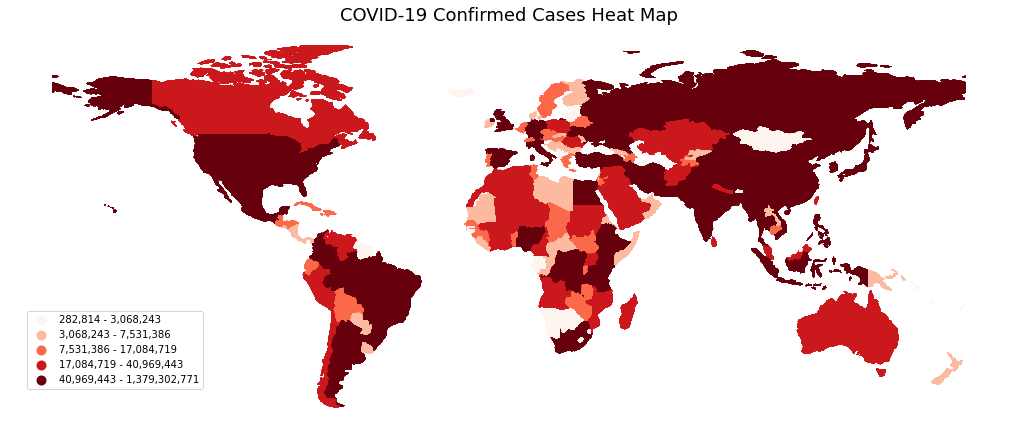

In [14]:
plot_map(data)

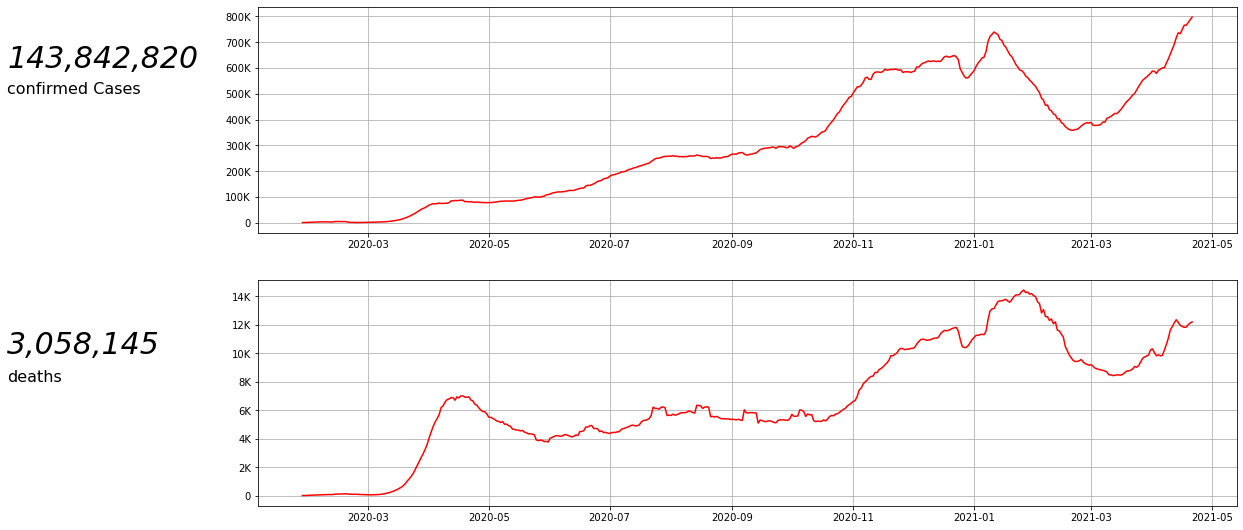

In [15]:
plot_world_trend(data)

In [16]:
populate_top15(data)

,Country,Total Cases,New Cases,Total Deaths,New Deaths
79337,United States,31862094.0,62857.0,569402.0,842.0
34645,India,15930774.0,314644.0,184657.0,2104.0
11070,Brazil,14122795.0,79719.0,381475.0,3472.0
27623,France,5436229.0,34924.0,102046.0,333.0
62106,Russia,4673699.0,8146.0,104937.0,392.0
77173,Turks and Caicos Islands,4446591.0,61967.0,36975.0,362.0
77094,Turkey,4446591.0,61967.0,36975.0,362.0
78881,United Kingdom,4411068.0,2424.0,127577.0,20.0
37736,Italy,3904899.0,13836.0,117997.0,364.0
70836,Spain,3446072.0,17718.0,77364.0,262.0


### Yes, Asia did well,  they have set a great example for the rest of the world

As can be seen from the figure below, most Asian countries’ prevention performance is significantly better than that of most European countries and the States. Western and eastern cultures are different from its very core, eastern cultures are more willing to sacrifice individual interests for the collective, while western cultures advocate individual heroism. However it is necessary to sacrifice some individual freedom in exchange for group security in the current extreme pandemic circumstances.

When the pandemic began to break out from January 2020 to February 2020 in China, its government intervention was promptly and forcefully involved. Wuhan announced the lockdown of the city, masks and green codes had become essential for travel and these measures had achieved great outcomes. Starting from the end of February 2020, the number of confirmed cases had dropped sharply, and this trend has continued to this day. Although the pandemic control in Japan and South Korea has fluctuated, the new cases have remained at a relatively low level. However, it is worth noting that new cases have begun to rise again, which may indicate a coming back of mass infection in the country.

On the other hand, the U.S. and most European countries did not respond actively to the warning issued by China to the World Health Organization at the beginning of the outbreak. When the pandemic began to spread to the world, the government was unable to give a strong force of applying effective anti-pandemic measures due to the tearing of ethnic groups in the society. The political parties are still fighting each other for unnecessary matters. (e.g Is wearing a mask necessary?) It was already too late when they discovered that the situation was out of control, and the United States soon became the largest virus warehouse in the world.

The number of new cases has started to climb at a rapid rate since the beginning of March in India, and recently it has exceeded 250,000 on a daily basis. India's is the second most populated country in the world, there is no doubt that it will replace the United States if the infection rate cannot be effectively controlled

Finally the figure indicates that seasons and climate have no much impact on the virus. There are signs of the virus coming back with multiple mutations.

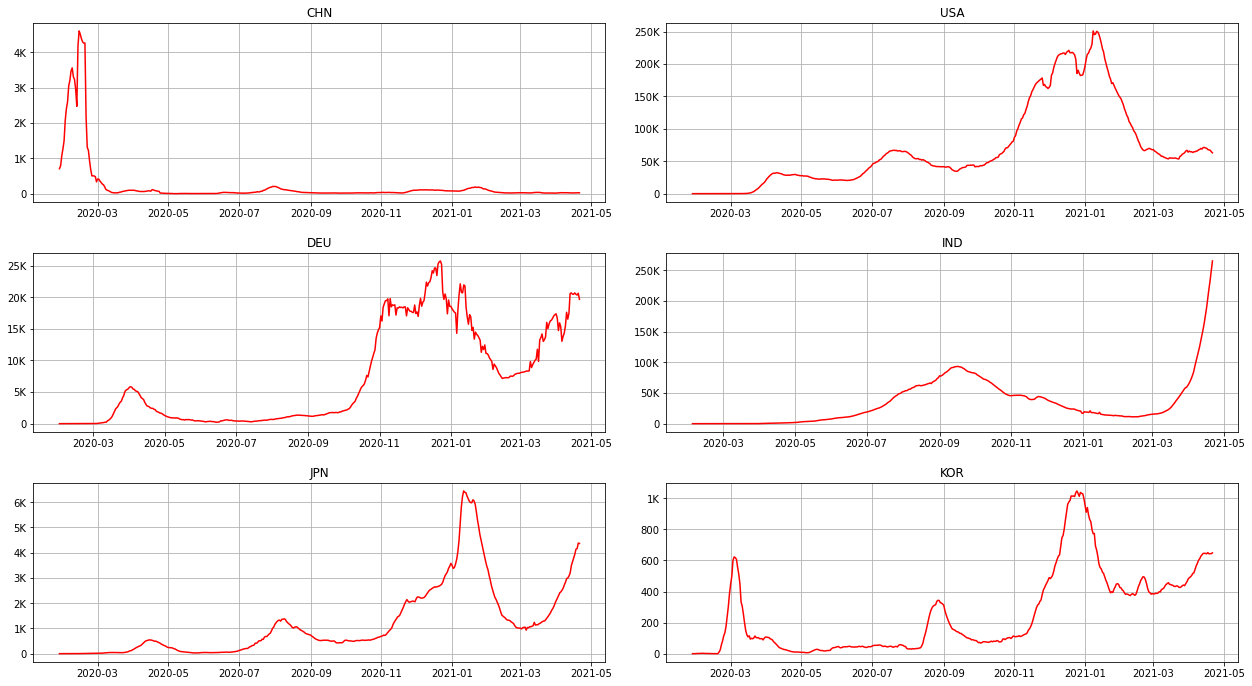

In [17]:
plot_new_cases(data)

### Elder people require higher hospitalization priority

The figure below groups the number of deaths by age and gender:

* The death rate of elder people infected by the virus is much higher than younger people.

* This virus also poses a greater threat to men than women. The number of deaths in men is significantly higher than numbers in women.

* Among people under 85 years of age, the death rate of men is higher, and for people over 85 years of age, the death rate of women is higher.

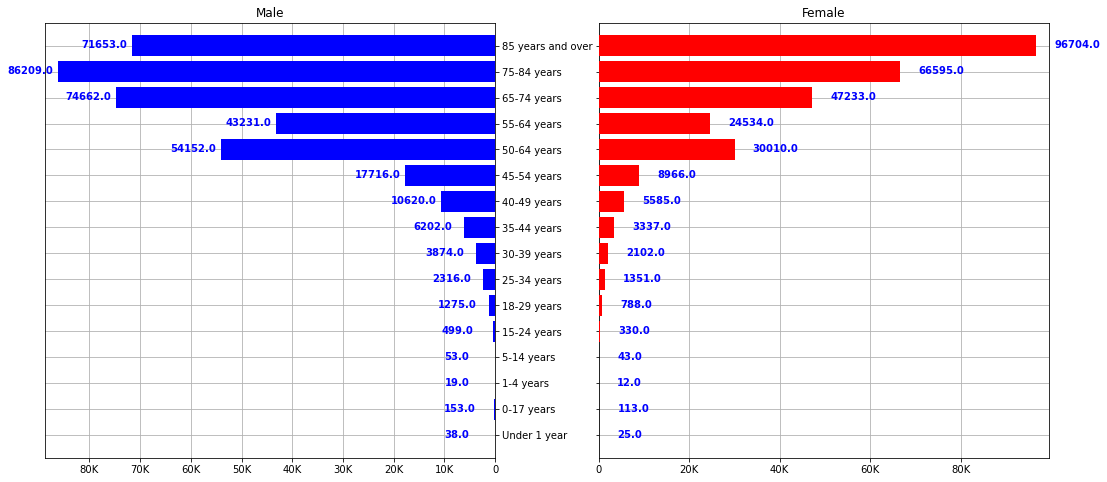

In [18]:
filepath = r"./covid_19_death_counts.csv"
data_dc = pd.read_csv(filepath, low_memory=False)
plot_death_age(data_dc)

### Young and middle-aged people are at high risk

The figure below shows the age distribution of the infected cases from March 29, 2020 to April 23, 2021. 

It indicates that 20 to 59 years old is a high-risk group of infections. Relevant studies have shown that young and middle-aged people usually have asymptomatic or mild symptoms due to their strong physical resistance. They are not aware that they have been infected, and thus they have made themselves the most dangerous nodes in the entire virus spread chain unintentionally. They frequently appear in crowded areas and usually result into a mass infection. The worst part is it is not traceable due to its asymptomatic symptoms.

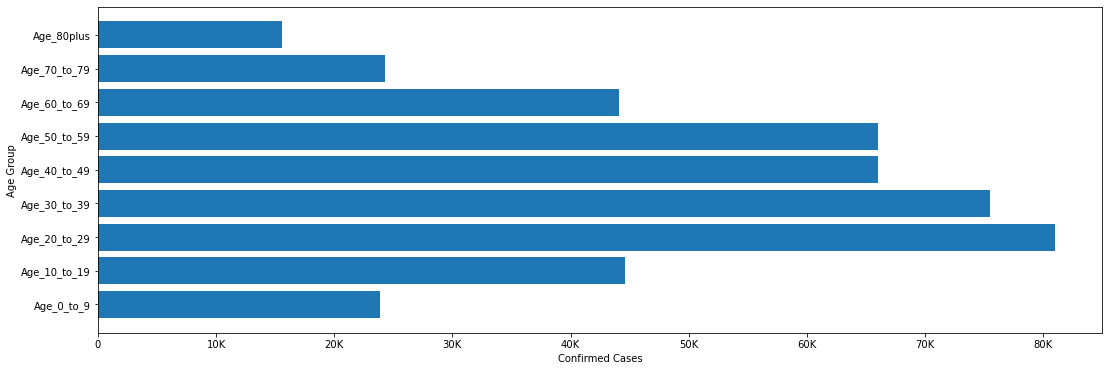

In [19]:
filepath = r"./covid_19_case_counts.csv"
data_cc = pd.read_csv(filepath, low_memory=False)    
plot_confirmed_age(data_cc)

### Vaccine production rate and supplies are the key factors 

Vaccines are the most effective means of pandemic prevention and control.

* The number of vaccinations in the world is still at a very low ratio. 
* The United States, the world's most powerful country, has its vaccinations ratio way ahead the average level of the world. 
* Although Europe's vaccination ratio is not comparable to the states, it is still on the right track and continues to improve. 
* However, India, the new "Rising Star" of infection and the second most populated country in the world, the 8.8% of vaccination rate is completely insufficient for its daily new cases. It may become the birthplace of the third outbreak if the situation is not going any better.

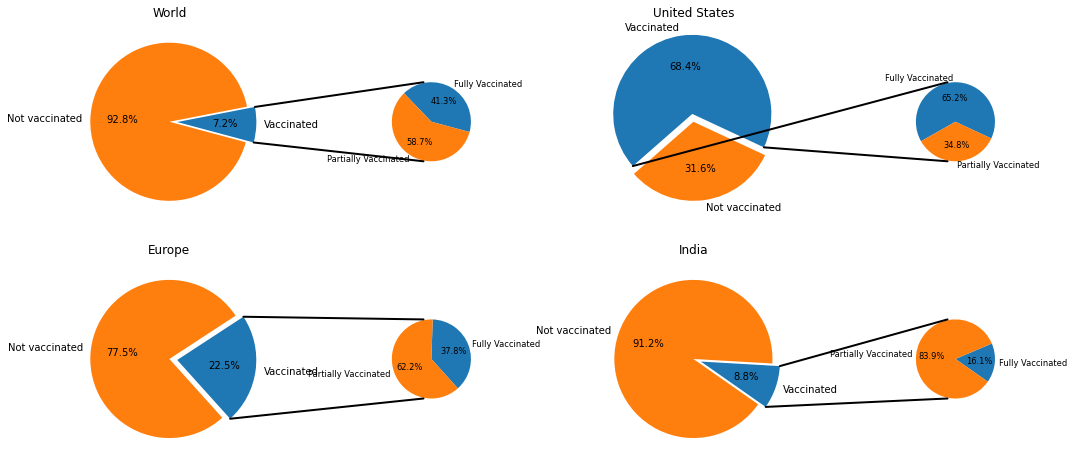

In [20]:
plot_pie(data)

### Conclusion

COVID-19 continues to spread, and we see no light of when it will end. Many people still do not realize that this is an extremely serious disaster. Their lack of knowledge about virus prevention and their contempt for the pandemic are likely to cause unpredictable harm to family and friends around them.

Until the day when the pandemic is completely over, mankind is a community of destiny during this period. We cannot lower our guard just because of the slight easing of the pandemic. Instead, we should maintain social distancing, disinfect regularly, vaccinate, and share your prevention knowledge.

Although the vaccine has been put on the market, the vaccination rate in developed countries has reached a pretty good level. However, there are still many countries and regions in the world that do not have the ability to develop vaccines, nor have they received enough supplies. Countries need to cooperate with each other, improve vaccine production efficiency, and provide assistance to countries with vaccine shortages.